0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Python 3.7.7 (default, May  7 2020, 21:25:33) 
Type 'copyright', 'credits' or 'license' for more information
IPython 7.22.0 -- An enhanced Interactive Python. Type '?' for help.

In [1]: exit()

30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
[3, 1, 0, 2, 3, 2, 0, 2, 3, 1, 0, 2, 3, 2, 0, 1, 3, 2, 0, 1, 3, 2, 0, 1, 0, 2, 0, 1, 0, 3, 2, 0, 1, 3, 1, 0, 2, 3, 2, 3, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 3, 2, 0, 1, 0, 2, 3, 2, 0, 1, 3, 1, 0, 2, 3, 2, 0, 2, 3, 2, 0, 1, 0, 2, 3, 2, 0, 1, 3, 2, 0, 1, 0, 2, 3, 2, 0, 1, 0, 2, 3, 2, 0, 1]
[1, 0, 2, 3, 2, 0, 2, 3, 1, 0, 2, 3, 2, 0, 1, 3, 2, 0, 1, 3, 2, 0, 1, 0, 2, 0, 1, 0, 2, 2, 0, 1, 3, 1, 0, 2, 3, 2, 3, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 3, 2, 0, 1, 0, 2, 3, 2, 0, 1, 3, 1, 0, 2, 3, 2, 0, 2, 3, 2, 0, 1, 0, 2, 3, 2, 0, 1, 3, 2, 0, 

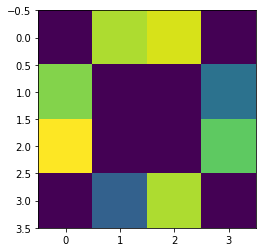

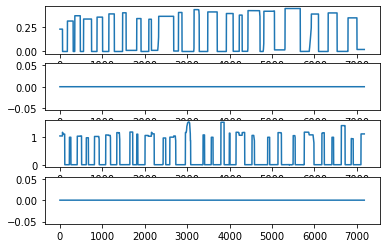

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import copy
import matplotlib
%matplotlib inline
sys.path.append("..")
from demo_2_awac import och_2_awac
import adept_envs
import gym

# Load in the data
all_paths = 'demo_list_2elements_PLAYSTYLE_June14.pkl'

paths = pickle.load(open(all_paths, 'rb'))
import itertools

def check_goal_completion(curr_pos):
    max_objs = np.array([0.17, 0.6])
    min_objs = np.array([0.08, 0.2])
    init_bitflips = np.array([0, 0])
    curr_bitflips = init_bitflips.copy()
    for j, pos_idx in enumerate([0, 2]):
        if curr_pos[pos_idx] > max_objs[j]:
            curr_bitflips[j] = 1
        elif curr_pos[pos_idx] < min_objs[j]:
            curr_bitflips[j] = 0
    new_idx = 2*curr_bitflips[0] + curr_bitflips[1]
    return new_idx


input_x = []
for path in paths:
    input_x.append(path['observations'][:-100])
input_x = np.concatenate(input_x, axis=0)[:, 2:6]

input_y = []
start_idxs = []
end_idxs = []
# Get labels
prev_idx = -1
curr_idx = -1

for j, path in enumerate(paths):
    print(j)
    curr_idx = check_goal_completion(path['observations'][0, 2:6])
    
    if curr_idx != prev_idx and prev_idx != -1:
        import IPython
        IPython.embed()
        
    for i in range(len(path['observations']) - 100):
        next_idx = check_goal_completion(path['observations'][-1, 2:6])
        input_y.append(next_idx)
        
    next_idx = check_goal_completion(path['observations'][0, 2:6])
    start_idxs.append(next_idx)
    next_idx = check_goal_completion(path['observations'][-1, 2:6])
    end_idxs.append(next_idx)
    
    prev_idx = next_idx
    
input_y = np.asarray(input_y)

print(start_idxs)
print(end_idxs)
adjacency_matrix = np.zeros((4,4))
for s, e in zip(start_idxs, end_idxs):
    adjacency_matrix[s, e] += 1


import matplotlib.pyplot as plt
plt.imshow(adjacency_matrix)
plt.show()

fig, ax = plt.subplots(4,1)
for i in range(4):
    ax[i].plot(input_x[:, i])

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from rlkit.torch.networks import ConcatMlp, Mlp
import torch
import torch.nn as nn
input_size = 4
num_goals = 4
batch_size = 32


goal_predictor = Mlp(
    input_size=input_size,
    output_size=num_goals,
    hidden_sizes=(256, 256, 256),
)

optimizer = torch.optim.Adam(goal_predictor.parameters())

idxs_data = np.array(range(len(input_x)))
np.random.shuffle(idxs_data)
num_train = int(0.9*len(idxs_data))

input_x_train = input_x[idxs_data[:num_train]]
input_x_test = input_x[idxs_data[num_train:]]

input_y_train = input_y[idxs_data[:num_train]]
input_y_test = input_y[idxs_data[num_train:]]

# TODO: Check the syntax
train_ds = TensorDataset(torch.Tensor(input_x_train), torch.Tensor(input_y_train).long())
test_ds = TensorDataset(torch.Tensor(input_x_test), torch.Tensor(input_y_test).long())

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = goal_predictor(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.8f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            outputs = goal_predictor(torch.Tensor(input_x_test))
            accuracy = np.sum(np.argmax(outputs.detach().numpy(), axis=1) == np.array(input_y_test, dtype=np.int32))/len(input_x_test)
            print('TEST %f \n'%accuracy*100)
            

print('Finished Training')

In [ ]:
for p in paths:
    o = p['observations'][0, 2:6]
    o[1] = 0.
    o = torch.Tensor(o)
    prediction = torch.nn.Softmax()(goal_predictor(o)).detach().numpy()
    print(prediction)
    print("START_IDX " + str(check_goal_completion(p['observations'][0, 2:6])))
    print("END_IDX " + str(check_goal_completion(p['observations'][-1, 2:6])))

In [ ]:
torch.save(goal_predictor, 'test_model_save_sim.pkl')

In [ ]:
dat = torch.load('test_model_save.pkl')

In [ ]:
goal_predictor.load_state_dict(dat.state_dict())